In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d

In [3]:
def sliar(y, t, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, nu_interp):
    S, L, I , A = y
    dydt = np.array([- beta * (1-sigma) * S * (epsilon * L + (1 - q) * I + delta * A) - nu_interp(t) * S,
                    beta * (1-sigma) * S * (epsilon * L + (1 - q) * I + delta * A) - kappa * L,
                    p * kappa * L - alpha * I - tau * I,
                    (1 - p) * kappa * L  - eta * A])
    return dydt

In [4]:
def adjoint_sliar(y, t, x_interp, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, nu_interp):
    l_S, l_L, l_I, l_A  = y
    S, L, I, A = x_interp(t)
    nu = nu_interp(t)
    dHdS = beta * (1 - sigma) * (epsilon * L + (1 - q) * I + delta * A) * (l_S - l_L) + nu * l_S
    dHdL = beta * (1 - sigma) * epsilon * S * (l_S - l_L) - kappa * p * (l_I - l_A) + kappa * (l_L - l_A)
    dHdI = -P + beta * (1 - q) * (1 - sigma) * S * (l_S - l_L) + l_I * (alpha + tau)
    dHdR = beta * (1 - sigma) * delta * S * (l_S - l_L) + eta * l_A
    return np.array([dHdS, dHdL, dHdI, dHdR])

In [5]:
import sympy as sp

S, L, I, A, nu = sp.symbols('S L I A nu')
beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q = sp.symbols('beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q')

l_S, l_L, l_I, l_A = sp.symbols('lambda_S lambda_L lambda_I lambda_A')
l = sp.Matrix([l_S, l_L, l_I, l_A])

f = P*I + Q * nu**2
g = sp.Matrix([- beta * (1-sigma) * S * (epsilon * L + (1 - q) * I + delta * A) - nu * S,
                beta * (1-sigma) * S * (epsilon * L + (1 - q) * I + delta * A) - kappa * L,
                p * kappa * L - alpha * I - tau * I,
                (1 - p) * kappa * L  - eta * A])

H = sp.Matrix([f + l.dot(g)])

In [11]:
H

Matrix([[I*P + Q*nu**2 + lambda_A*(-A*eta + L*kappa*(1 - p)) + lambda_I*(-I*alpha - I*tau + L*kappa*p) + lambda_L*(-L*kappa + S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon)) + lambda_S*(-S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) - S*nu)]])

In [10]:
sp.latex(H)

'\\left[\\begin{matrix}I P + Q \\nu^{2} + \\lambda_{A} \\left(- A \\eta + L \\kappa \\left(1 - p\\right)\\right) + \\lambda_{I} \\left(- I \\alpha - I \\tau + L \\kappa p\\right) + \\lambda_{L} \\left(- L \\kappa + S \\beta \\left(1 - \\sigma\\right) \\left(A \\delta + I \\left(1 - q\\right) + L \\epsilon\\right)\\right) + \\lambda_{S} \\left(- S \\beta \\left(1 - \\sigma\\right) \\left(A \\delta + I \\left(1 - q\\right) + L \\epsilon\\right) - S \\nu\\right)\\end{matrix}\\right]'

In [9]:
dHdx = H.jacobian([S, L, I, A])
dHdx

Matrix([[beta*lambda_L*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) + lambda_S*(-beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) - nu), -S*beta*epsilon*lambda_S*(1 - sigma) + kappa*lambda_A*(1 - p) + kappa*lambda_I*p + lambda_L*(S*beta*epsilon*(1 - sigma) - kappa), P + S*beta*lambda_L*(1 - q)*(1 - sigma) - S*beta*lambda_S*(1 - q)*(1 - sigma) + lambda_I*(-alpha - tau), S*beta*delta*lambda_L*(1 - sigma) - S*beta*delta*lambda_S*(1 - sigma) - eta*lambda_A]])

In [57]:
dHdl = H.jacobian([l_S, l_L, l_I, l_A])
dHdl

Matrix([[-S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon) - S*nu, -L*kappa + S*beta*(1 - sigma)*(A*delta + I*(1 - q) + L*epsilon), -I*alpha - I*tau + L*kappa*p, -A*eta + L*kappa*(1 - p)]])

In [58]:
dHdnu = H.jacobian([nu])
dHdnu

Matrix([[2*Q*nu - S*lambda_S]])

In [59]:
dHdx_fn = sp.lambdify([l_S, l_L, l_I, l_A, S, L, I, A, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu], dHdx)
dHdl_fn = sp.lambdify([l_S, l_L, l_I, l_A, S, L, I, A, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu], dHdl)
dHdnu_fn = sp.lambdify([l_S, l_L, l_I, l_A, S, L, I, A, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu], dHdnu)

In [60]:
def sliar_by_sympy(y, t, beta_, sigma_, kappa_, alpha_, tau_, p_, eta_, epsilon_, q_, delta_, P, Q, nu_interp):
    S_, L_, I_, A_ = y
    nu_ = nu_interp(t)
    return dHdl_fn(0, 0, 0, 0, S_, L_, I_, A_, beta_, sigma_, kappa_, alpha_, tau_, p_, eta_, epsilon_, q_, delta_, P, Q, nu_)[0]

In [61]:
def adjoint_sliar_by_sympy(y, t, x_interp, beta_, sigma_, kappa_, alpha_, tau_, p_, eta_, epsilon_, q_, delta_, P_, Q_, nu_interp):
    l_S_, l_L_, l_I_, l_A_  = y
    S_, L_, I_, A_ = x_interp(t)
    nu_ = nu_interp(t)
    val = -dHdx_fn(l_S_, l_L_, l_I_, l_A_, S_, L_, I_, A_, beta_, sigma_, kappa_, alpha_, tau_, p_, eta_, epsilon_, q_, delta_, P_, Q_, nu_)[0]
    return val

In [62]:
t0 = 0
tf = 300
S0 = 1000000
L0 = 0
I0 = 1
A0 = 0
sigma = 0 
kappa = 0.526
alpha = 0.244
tau = 0
p = 0.667
eta = 0.244
epsilon = 0
q = 0.5
delta = 1
R0 = 1.9847
beta = R0/(S0 * ((epsilon / kappa) + ((1 - q)*p/alpha) + (delta*(1-p)/eta)))
P = 1
Q = 1
beta

7.265818454613654e-07

In [63]:
# Initial
y0 = np.array([S0, L0, I0, A0])
t = np.linspace(t0, tf, 301)
dt = t[1] - t[0]
#np.ones_like() : 동일한 사이즈로 ones 매트릭스 만듬
nu0 = np.ones_like(t)
nu0_ = np.zeros_like(t)
print(y0)
print(dt)
print(nu0)

[1000000       0       1       0]
1.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [64]:
nu_intp = lambda tc: np.interp(tc, t, nu0_)
sol = odeint(sliar, y0, t, args=(beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, nu_intp))
print(sol)

[[1.00000000e+06 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [9.99999665e+05 2.58671650e-01 8.29994330e-01 2.32184847e-02]
 [9.99999346e+05 4.01476938e-01 7.55668385e-01 7.08014473e-02]
 ...
 [2.07411026e+05 9.95858481e-06 2.71574583e-05 1.35583712e-05]
 [2.07411026e+05 8.87270923e-06 2.41961069e-05 1.20799154e-05]
 [2.07411026e+05 7.90841444e-06 2.15663196e-05 1.07669932e-05]]


In [67]:
# Initial
y0 = np.array([S0, L0, I0, A0])
t = np.linspace(t0, tf, 301)
dt = t[1] - t[0]
#np.ones_like() : 동일한 사이즈로 ones 매트릭스 만듬
nu0 = np.ones_like(t)

MaxIter = 100000
alpha = 1E-5
old_cost = 1E8
for it in range(MaxIter + 1):
    # State (Forward)
    nu_intp = lambda tc: np.interp(tc, t, nu0)
    sol = odeint(sliar_by_sympy, y0, t, args=(beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_intp))

    # Cost
    S, L, I, A = np.hsplit(sol, 4)
    S_mid = (S[1:] + S[:-1]) / 2.
    L_mid = (L[1:] + L[:-1]) / 2.
    I_mid = (I[1:] + I[:-1]) / 2.
    A_mid = (A[1:] + A[:-1]) / 2.
    nu_mid = (nu0[1:] + nu0[:-1]) / 2.
    cost1 = dt * np.sum(I_mid.flatten())
    cost2 = dt * np.sum(nu_mid.flatten() ** 2)
    cost = cost1 + cost2

    # Adjoint (Backward)
    nu_intp = lambda tc: np.interp(tf - tc, t, nu0)
    x_intp = lambda tc: np.array([np.interp(tf - tc, t, sol[:, 0]), np.interp(tf - tc, t, sol[:, 1]), np.interp(tf - tc, t, sol[:, 2]), np.interp(tf - tc, t, sol[:, 3])])
    y_T = np.array([0,0,0,0])
    l_sol = odeint(adjoint_sliar_by_sympy, y_T, t, args=(x_intp, beta, sigma, kappa, alpha, tau, p, eta, epsilon, q, delta, P, Q, nu_intp))


    # Simple Gradient
    # FOR optimality condition
    Hnu = 2 * P * nu0 - l_sol[:,0] * sol[:, 0]
    nu1 = np.clip(nu0 - alpha * Hnu , 0, 1)

    if old_cost > cost:
        alpha = alpha / 10 # simple adaptive learning rate

    # Convergence
    if np.abs(old_cost - cost) / alpha  <= 1E-7:
        break

    old_cost = cost
    nu0 = nu1


ValueError: object too deep for desired array

In [ ]:
print(dHdnu)
print(it)
print(cost)

Matrix([[-S*lambda_S + 2*nu]])
362
162629186.59070295


<Figure size 640x480 with 0 Axes>

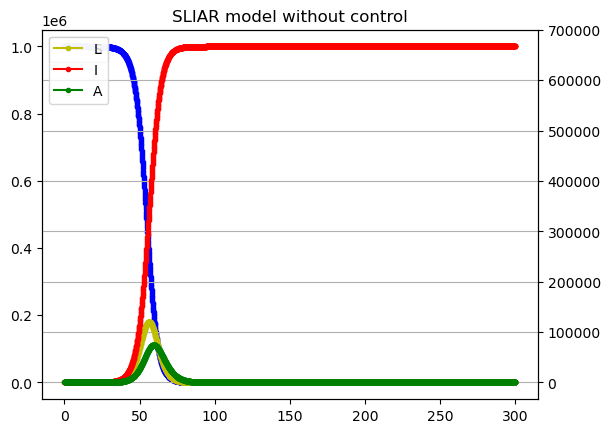

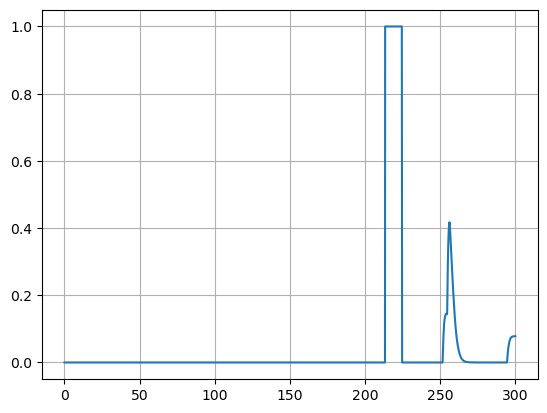

In [ ]:
import matplotlib.pylab as plt
plt.clf()
fig, ax1 = plt.subplots()
ax1.plot(t, sol[:,0], '.-b', label = 'S')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(t, sol[:,1], '.-y', label = 'L')
ax2.plot(t, sol[:,2], '.-r', label = 'I')
ax2.plot(t, sol[:,3], '.-g', label = 'A')
ax2.legend(loc='lower right')
plt.grid()
plt.legend()
plt.title('SLIAR model without control')
plt.xlabel('day')
plt.savefig('SLIAR_wo_control_adj.png', dpi=300)
plt.show(block=False)


plt.plot(t, nu0)
plt.grid()
plt.show()